# 3. Confined Aquifer Test - Sioux Flats

### Import packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import timflow.transient as tft

plt.rcParams["figure.figsize"] = (5, 3)  # default figure size

### Introduction and Conceptual Model

This example is a pumping test done in Sioux Flats, South Dakota, USA. The data comes from the AQTESOLV documentation (Duffield, 2007). 

The aquifer is 50 ft thick and is bounded by impermeable layers. The test was conducted for 2045 minutes (~34 hours), with a constant pumping rate of 2.7 $ft^3/s$. Drawdown data has been collected at three piezometers located 100, 200 and 400 ft away, respectively. The well radius is 0.5 ft. 

<img src="./figs/Sioux.png" style="width:400pt">

### Load data

In [11]:
# time and drawdown of piezometer 100ft away from pumping well
data1 = np.loadtxt("data/sioux100.txt")
t1 = data1[:, 0] 
h1 = data1[:, 1] 
 
# time and drawdown of piezometer 200ft away from pumping well
data2 = np.loadtxt("data/sioux200.txt")
t2 = data2[:, 0]
h2 = data2[:, 1]

# time and drawdown of piezometer 300ft away from pumping well
data3 = np.loadtxt("data/sioux400.txt")
t3 = data3[:, 0]
h3 = data3[:, 1]

### Parameters and model

In [14]:
# known parameters
Q = (2.7 * 0.3048**3) * 60 * 60 * 24 # constant discharge in m^3/d (2.7 ft^3/s = 6605.754 m^3/d)
b = -50 * 0.3048  # aquifer thickness in m (50 ft = 15.24 m)
rw = 0.5 * 0.3048 # well radius in m (0.5 ft = 0.1524 m) 
r1 = 100 * 0.3048# distance between obs1 to pumping well (100 ft = 30.48 m)
r2 = 200 * 0.3048 # distance between obs2 to pumping well (200 ft = 60.96 m)
r3 = 400 * 0.3048  # distance between obs3 to pumping well (400 ft = 121.92 m)

In [16]:
# timflow model
ml = tft.ModelMaq(kaq=10, z=[0, b], Saq=0.001, tmin=0.001, tmax=10, topboundary="conf")
w = tft.Well(ml, xw=0, yw=0, rw=rw, tsandQ=[(0, Q)], layers=0)
ml.solve()

self.neq  1
solution complete


### Estimate aquifer parameters

In [18]:
# unknown parameters: k, Saq
cal = tft.Calibrate(ml)
cal.set_parameter(name="kaq", initial=10, layers=0)
cal.set_parameter(name="Saq", initial=1e-4, layers=0)
cal.series(name="obs1", x=r1, y=0, t=t1, h=h1, layer=0) # Adding well 1
cal.series(name="obs2", x=r2, y=0, t=t2, h=h2, layer=0) # Adding well 2
cal.series(name="obs3", x=r3, y=0, t=t3, h=h3, layer=0) # Adding well 3
cal.fit(report=True)

......................................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 35
    # data points      = 77
    # variables        = 2
    chi-square         = 0.00121634
    reduced chi-square = 1.6218e-05
    Akaike info crit   = -847.289903
    Bayesian info crit = -842.602292
[[Variables]]
    kaq_0_0:  282.795208 +/- 1.13789472 (0.40%) (init = 10)
    Saq_0_0:  0.00420855 +/- 3.3461e-05 (0.80%) (init = 0.0001)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq_0_0, Saq_0_0) = -0.8113


In [20]:
display(cal.parameters)
print("RMSE:", cal.rmse())

,layers,optimal,std,perc_std,pmin,pmax,initial,inhoms,parray
kaq_0_0,0,282.795208,1.137895,0.402374,-inf,inf,10.0000,None,[[282.7952077845511]]
Saq_0_0,0,0.004209,0.000033,0.795070,-inf,inf,0.0001,None,[[0.004208548562555498]]


RMSE: 0.003974499249718837


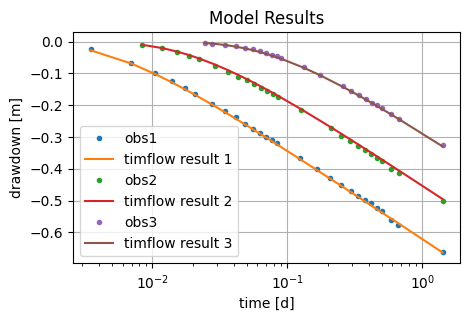

In [33]:
hm1 = ml.head(r1, 0, t1)
hm2 = ml.head(r2, 0, t2)
hm3 = ml.head(r3, 0, t3)
plt.semilogx(t1, h1, ".", label="obs1")
plt.semilogx(t1, hm1[0], label="timflow result 1")
plt.semilogx(t2, h2, ".", label="obs2")
plt.semilogx(t2, hm2[0], label="timflow result 2")
plt.semilogx(t3, h3, ".", label="obs3")
plt.semilogx(t3, hm3[0], label="timflow result 3")
plt.title("Model Results")
plt.xlabel("time [d]")
plt.ylabel("drawdown [m]")
plt.legend()
plt.grid()

### Comparison of results
The performance of `timflow` was evaluated by comparison with AQTESOLV (Duffield, 2007), and MLU (Carlson and Randall, 2012). In both software, the model was calibrated with observations. `timflow` achieved similar results as the other software. 

In [23]:
t = pd.DataFrame(
    columns=["k [m/d]", "Ss [1/m]", "RMSE [m]"], 
    index=["timflow", "AQTESOLV", "MLU"]
)

t.loc["timflow"] = np.append(cal.parameters["optimal"].values, cal.rmse())
t.loc["AQTESOLV"] = [282.659, 4.211e-03, 0.003925]
t.loc["MLU"] = [282.684, 4.209e-03, 0.003897]

t_formatted = t.style.format(
    {"k [m/d]": "{:.2f}", "Ss [1/m]": "{:.2e}", "RMSE [m]": "{:.3f}"}
)
t_formatted

,k [m/d],Ss [1/m],RMSE [m]
timflow,282.80,4.21e-03,0.004
AQTESOLV,282.66,4.21e-03,0.004
MLU,282.68,4.21e-03,0.004


## References

* Carlson, F. and Randall, J. (2012), MLU: a Windows application for the analysis of aquifer tests and the design of well fields in layered systems, Ground Water 50(4):504–510
* Duffield, G.M. (2007), AQTESOLV for Windows Version 4.5 User's Guide, HydroSOLVE, Inc., Reston, VA.
* Newville, M., Stensitzki, T., Allen, D.B., Ingargiola, A. (2014), LMFIT: Non Linear Least-Squares Minimization and Curve Fitting for Python, https://dx.doi.org/10.5281/zenodo.11813, https://lmfit.github.io/lmfit-py/intro.html (last access: August,2021).